This is from

 https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/#research-team


In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tavily_tool = TavilySearch(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [29]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"



In [40]:
from langchain.agents import create_agent


agent = create_agent(
    model='gpt-4o-mini', 
    tools=[read_document, create_outline],
    system_prompt=("you are a professional writer"))
    

In [66]:
class State(MessagesState):
    next: str


#state = MessagesState()
state

{'messages': 'hi'}

In [65]:
state['messages']="hi"

In [ ]:
note_taking_agent.invoke(state)


BadRequestError: Error code: 400 - {'error': {'message': "Invalid type for 'messages[0].content[0]': expected an object, but got a string instead.", 'type': 'invalid_request_error', 'param': 'messages[0].content[0]', 'code': 'invalid_type'}}

In [46]:
note_taking_agent.invoke({"messages": [HumanMessage(content="create an outlline for a novel  about cats")]})

BadRequestError: Error code: 400 - {'error': {'message': "Invalid type for 'messages[0].content[0]': expected an object, but got a string instead.", 'type': 'invalid_request_error', 'param': 'messages[0].content[0]', 'code': 'invalid_type'}}

In [ ]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

In [45]:
_TEMP_DIRECTORY

<TemporaryDirectory '/var/folders/bz/qcwzc_9j6zgggtsc_fbjryy40000gp/T/tmp2tu46n0v'>

In [32]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent

llm = ChatOpenAI(model="gpt-4o")

search_agent = create_agent(llm, tools=[tavily_tool])


def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


web_scraper_agent = create_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

In [12]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

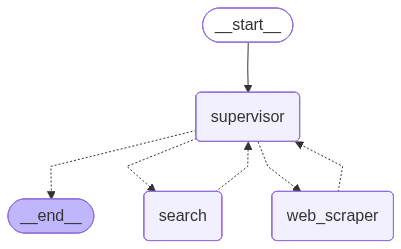

In [13]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [14]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='Taylor Swift\'s next tour, known as "The Eras Tour," will continue with new dates in 2024. The North American leg of her tour will kick off on October 18, 2024. Additionally, she has added dates in December 2024 in Vancouver, Canada. Here are some specific dates for her upcoming shows:\n\n- Vancouver: December 6, 7, 8, 2024\n- Miami, New Orleans, Indianapolis, and Toronto will also have tour dates in 2024.\n\nFor more information, you can check [this link](https://www.ticketsmarter.com/insider/concerts/artists-tour-dates/pop/taylor-swift-the-eras-tour/) and [here](https://blog.ticketmaster.com/taylor-swift-the-eras-tour-2024/).', additional_kwargs={}, response_metadata={}, name='search', id='e61d6419-5038-434b-b1e2-f0b9ab0f2ceb')]}}
---
{'supervisor': {'next': '__end__'}}
---


In [71]:
llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    system_prompt=("""You can read, write and edit documents based on note-taker's outlines.
        Don't ask follow-up questions."""
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_agent(
    llm,
    tools=[create_outline, read_document],
    system_prompt=("""You can read documents and create outlines for the document writer. 
        Don't ask follow-up questions."""
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    if not result:
        raise(Exception("No result error in note_taking_agent"))
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )





doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker"]
)

In [72]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

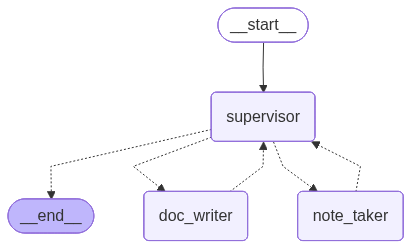

In [73]:
display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [74]:
paper_writing_graph.invoke({"messages": [HumanMessage(content=f"Write an outline for poem about cats.")]})

{'messages': [HumanMessage(content='Write an outline for poem about cats.', additional_kwargs={}, response_metadata={}, id='fe33c530-9d25-4a50-b27b-5d5c0e938598'),
  HumanMessage(content='The outline for the poem about cats has been created and saved as "poem_about_cats_outline.txt".', additional_kwargs={}, response_metadata={}, name='note_taker', id='ccee7c98-1111-4d2c-a1e2-983718f86d09'),
  HumanMessage(content="Here's the outline for the poem about cats:\n\n1. **Introduction to Cats: Their Elegance and Mystery**\n   \n2. **Playfulness and Grace: A Joyful Presence**\n\n3. **Independent Spirits: The Enigmatic Nature**\n\n4. **Cats and Their Whimsical Habits**\n\n5. **The Bond Between Humans and Cats: A Unique Friendship**\n\n6. **Concluding Thoughts: Celebrating the Feline Essence**", additional_kwargs={}, response_metadata={}, name='doc_writer', id='8ec19a58-2bf0-4f29-be5f-0194b243b1a0'),
  HumanMessage(content='Great! The outline for your poem about cats has been structured and save

In [75]:
for s in paper_writing_graph.stream(
    {
        "messages": [HumanMessage(content=f"Write an outline for poem about cats and then write the poem to disk.")]
        
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='The outline for the poem about cats has been created and saved to "cat_poem_outline.txt".', additional_kwargs={}, response_metadata={}, name='note_taker', id='ffd7bba1-3120-487e-958d-8a2614a1b96f')]}}
---
{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='The poem about cats has been written and saved to "cat_poem.txt".', additional_kwargs={}, response_metadata={}, name='doc_writer', id='419ed20e-8956-4958-8999-6e64fa7db817')]}}
---
{'supervisor': {'next': '__end__'}}
---


In [76]:
# Adding layers - new graph to orchestrate between the 2 already created

from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [77]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

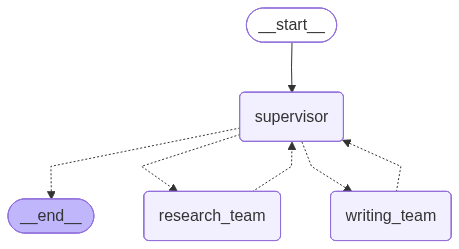

In [78]:
display(Image(super_graph.get_graph().draw_mermaid_png()))


In [79]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content='## AI Agents: A Brief Overview\n\n### Definition and Functionality\nAI agents are sophisticated software systems designed to achieve specific objectives by interacting with their environment. These agents can observe their surroundings, assess context, and autonomously make decisions to reach defined goals. They leverage artificial intelligence models to process information, adapt to new information, and take actions with minimal human oversight.\n\n### Types of AI Agents\nAI agents can be categorized into several types, each serving distinct functions:\n\n1. **Reflex Agents**: Operate on predefined rules without memory or environmental mapping, suitable for repetitive tasks.\n2. **Model-Based Reflex Agents**: Use an internal model of the world to operate, enhancing decision-making capabilities.\n3. **Goal-Based Agents**: Take actions based on achieving specified goals.\n4. **Utility-Bas

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/bz/qcwzc_9j6zgggtsc_fbjryy40000gp/T/tmp2tu46n0v/note_taker_outline.txt'

In [81]:
ls /var/folders/bz/qcwzc_9j6zgggtsc_fbjryy40000gp/T/tmp2tu46n0v

AI_Agents_Overview_Outline.txt  cat_poem_outline.txt
cat_novel_outline.txt           poem_about_cats_outline.txt
cat_poem.txt
